In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [ ]:
from ncf import NCF
import torch
import os
device ='cuda:0'
train_data_path = "../data/flickr/processed/train/"
test_data_path = "../data/flickr/processed/test/"
irt_models_path = "../data/flickr/evaluation/irt_models/"
ncf_model_path = "../data/flickr/evaluation/classifier/"


In [4]:
ncf_prior_path = "ncf_scorer.pkl"
ncf_prior = NCF()
ncf_prior.load(f"{ncf_model_path}/{ncf_prior_path}")
ncf_model_file = "ncf_scorer_ViT-G.pkl"
ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
data_test = pd.read_csv(test_data_path+"test_usrthrs_0.csv")
E_test = torch.load(test_data_path+"test_ie_sdxl.pt", weights_only=True)
U_test = torch.tensor(data_test.worker_id)

In [7]:
from diffusers import StableDiffusionXLPipeline
pipe_xl = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
pipe_xl.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

eval_dir = '../data/flickr/evaluation/'
rebeca_dir = f"{eval_dir}/diffusion_priors/models/"

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
pipe_cfg = 5.0
embcfg = 5.0
seed = 42

prefix = f"embcfg_{embcfg}_pipecfg_{pipe_cfg}_seed_{seed}"
data_dir = f"../data/flickr/evaluation/diffusion_priors/models/samples/{prefix}"
user_idx = range(210)

prior_embeddings, posterior_embeddings = [], []
rebeca_embeddings = []

for user_id in tqdm(user_idx):
    user_data = torch.load(f"{data_dir}/{prefix}_userid_{user_id}.data", weights_only=False)
    prior_embeddings.append(user_data["prior_embeddings"])
    #posterior_embeddings.append(user_data["posterior_embeddings"])
    rebeca_user_images = torch.load(f"{rebeca_dir}/samples/embcfg_5.0_pipecfg_5.0_seed_42/embcfg_5.0_pipecfg_5.0_seed_42_userid_{user_id}.data", weights_only=False)["images"]
    
    for img in rebeca_user_images:
        rebeca_embeddings.append(pipe_xl.encode_image(img, device="cuda", num_images_per_prompt=1)[0].detach().cpu())
prior_embeddings = torch.cat(prior_embeddings)
posterior_embeddings = torch.cat(rebeca_embeddings)

u_ids = torch.tensor([i//25 for i in range(prior_embeddings.shape[0])])


100%|██████████| 210/210 [01:34<00:00,  2.23it/s]


In [9]:
n_perms = 1000
perm_prior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in tqdm(range(n_perms), desc="Prior Permutations"):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    prior_scores = ncf_prior.score(u_perm, prior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([prior_scores[j]["avg"] for j in prior_scores.keys()])
    perm_prior_tensor[i] = perm_avgs


n_perms = 1000
perm_posterior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in  tqdm(range(n_perms), desc="Posterior Permutations"):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    posterior_scores = ncf.score(u_perm, posterior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([posterior_scores[j]["avg"] for j in posterior_scores.keys()])
    perm_posterior_tensor[i] = perm_avgs


real_prior_scores = ncf_prior.score(u_ids, prior_embeddings.to(torch.float32))
real_prior_avgs = torch.tensor([real_prior_scores[i]["avg"] for i in real_prior_scores.keys()])
real_posterior_scores = ncf.score(u_ids, posterior_embeddings.to(torch.float32))
real_posterior_avgs = torch.tensor([real_posterior_scores[i]["avg"] for i in real_posterior_scores.keys()])


perm_prior_means = perm_prior_tensor.mean(dim=1)
perm_prior_medians = perm_prior_tensor.median(dim=1).values
perm_posterior_means = perm_posterior_tensor.mean(dim=1)
perm_posterior_medians = perm_posterior_tensor.median(dim=1).values




Posterior Permutations: 100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]


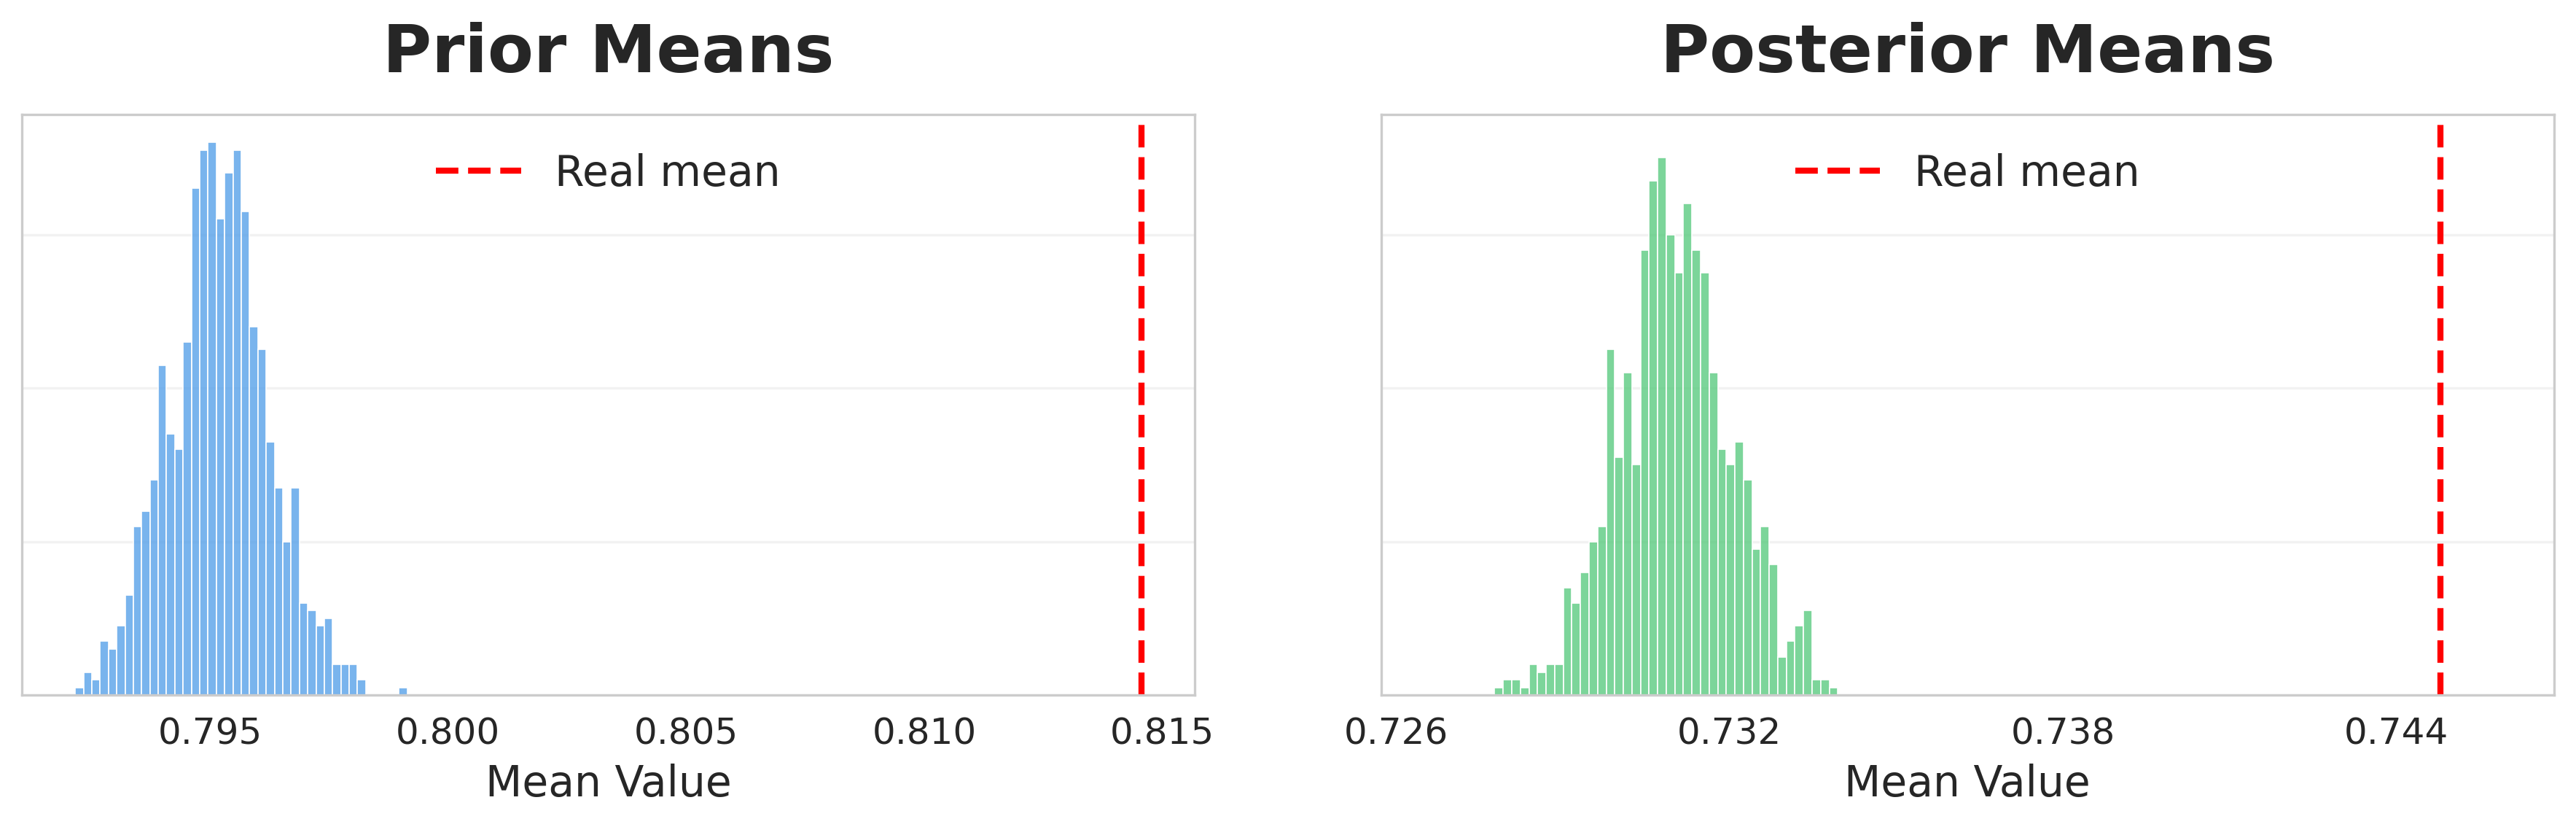

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# ---- CVPR-style aesthetics (keep yours) ----
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 22,      # bigger titles like in your screenshot
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.transparent": True,
})
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ---------- Prior ----------
sns.histplot(perm_prior_means, bins=40, kde=False, color="#4C9BE8",
             edgecolor="white", lw=0.4, ax=axes[0])
axes[0].axvline(real_prior_avgs.mean(), color="red", ls="--", lw=2, label="Real mean")
axes[0].set_title("Prior Means", weight="bold", pad=14)
axes[0].set_xlabel("Mean Value")
axes[0].set_ylabel("")
axes[0].tick_params(axis="y", left=False, labelleft=False)
axes[0].legend(frameon=False, loc="upper center")
# Make ticks readable
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].xaxis.set_major_formatter(FormatStrFormatter("%.3f"))

# ---------- Posterior ----------
sns.histplot(perm_posterior_means, bins=40, kde=False, color="#50C878",
             edgecolor="white", lw=0.4, ax=axes[1])
axes[1].axvline(real_posterior_avgs.mean(), color="red", ls="--", lw=2, label="Real mean")
axes[1].set_title("Posterior Means", weight="bold", pad=14)
axes[1].set_xlabel("Mean Value")
axes[1].set_ylabel("")
axes[1].tick_params(axis="y", left=False, labelleft=False)
axes[1].legend(frameon=False, loc="upper center")

# Fix the cramped ticks: fewer ticks + 3 decimals + a bit of padding
lo = float(min(perm_posterior_means.min(), real_posterior_avgs.mean()))
hi = float(max(perm_posterior_means.max(), real_posterior_avgs.mean()))
pad = max(1e-4, 0.12 * (hi - lo))  # gentle padding if the range is tiny
axes[1].set_xlim(lo - pad, hi + pad)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=4))
axes[1].xaxis.set_major_formatter(FormatStrFormatter("%.3f"))

# Optional: horizontal grid only (cleaner)
for ax in axes:
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

plt.tight_layout(w_pad=2.8)
plt.savefig("./outputs/evaluation/prior_posterior_means_comparison.pdf", bbox_inches="tight")
plt.savefig("./outputs/evaluation/prior_posterior_means_comparison.png", bbox_inches="tight", dpi=600)
plt.show()


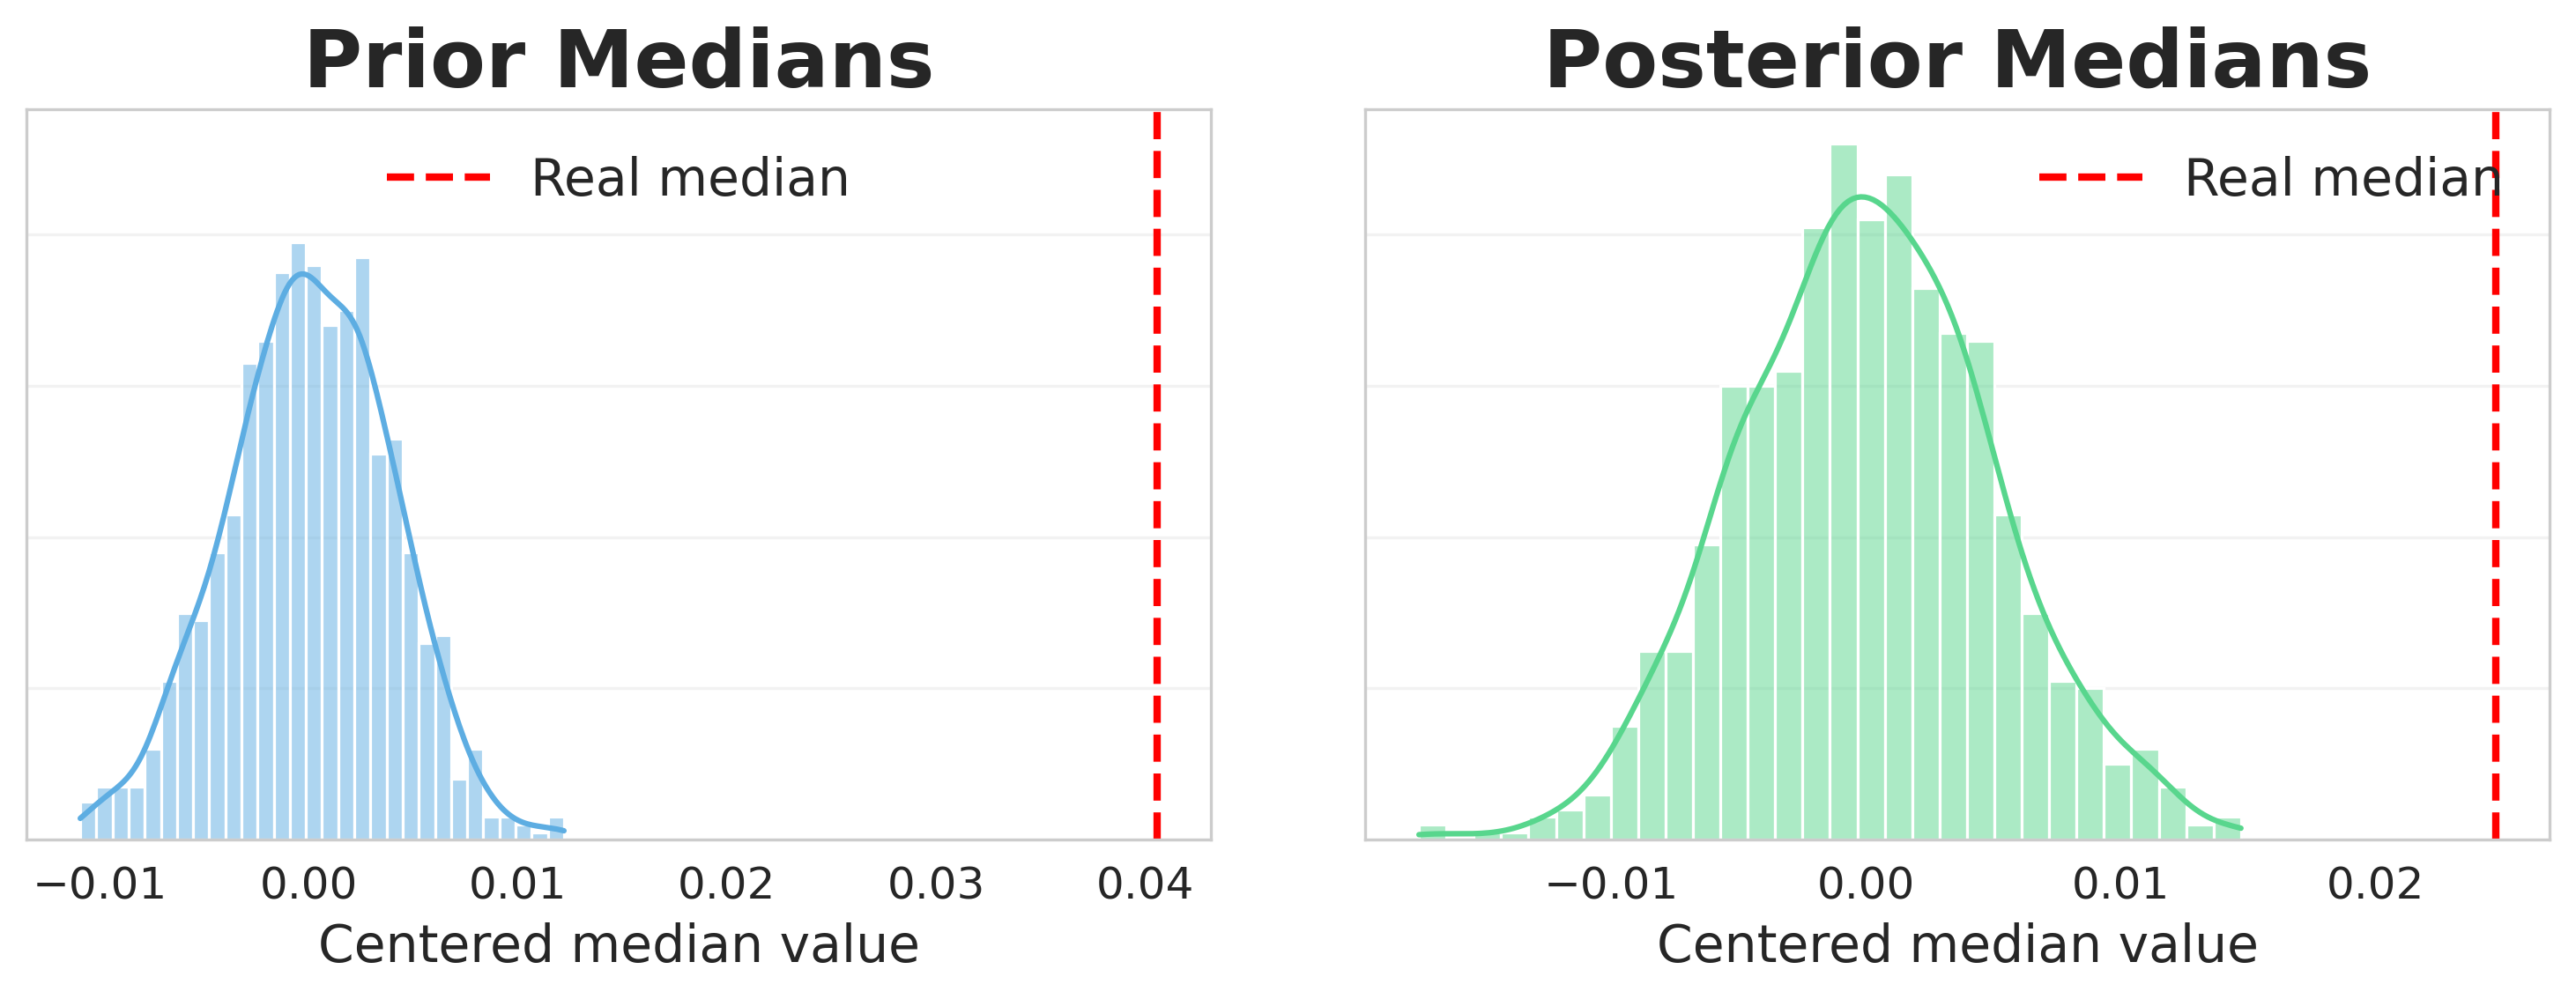

In [11]:
# ---- Create side-by-side figure ----
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Prior means
sns.histplot(perm_prior_medians - perm_prior_medians.mean(), bins=30, stat="probability", kde=True, color="#5DADE2", ax=axes[0])
axes[0].axvline(real_prior_avgs.median() - perm_prior_medians.mean(), color="red", linestyle="--", linewidth=2, label="Real median")
axes[0].set_title("Prior Medians", weight="bold")
axes[0].set_xlabel("Centered median value")
axes[0].set_ylabel("")
axes[0].tick_params(axis='y', which='both', left=False, labelleft=False)  # remove y-ticks
axes[0].legend(frameon=False, loc="upper center")

# Posterior means
sns.histplot(perm_posterior_medians - perm_posterior_medians.mean(), bins=30, stat="probability", kde=True, color="#58D68D", ax=axes[1])
axes[1].axvline(real_posterior_avgs.median() - perm_posterior_medians.mean(), color="red", linestyle="--", linewidth=2, label="Real median")
axes[1].set_title("Posterior Medians", weight="bold")
axes[1].set_xlabel("Centered median value")
axes[1].set_ylabel("")
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)  # remove y-ticks
axes[1].legend(frameon=False)


for ax in axes:
    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=0.25)

# ---- Layout and export ----
plt.tight_layout(w_pad=3)
plt.savefig("prior_posterior_medians_comparison.pdf", bbox_inches="tight", dpi=600)
plt.show()

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def freedman_diaconis_bins(x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return 10
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    if iqr == 0:
        return min(50, max(10, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        return min(50, max(10, int(np.sqrt(n))))
    return int(np.clip(np.ceil((x.max() - x.min()) / h), 20, 80))

def plot_posterior_median_permutation_test(perm_posterior_medians,
                                           real_posterior_values,
                                           outfile_pdf="posterior_medians_permtest.pdf",
                                           outfile_png="posterior_medians_permtest.png"):
    """
    perm_posterior_medians: 1D array-like of permutation-summary statistics (medians)
    real_posterior_values: 1D array-like of real-sample values to compute its median (or pass a scalar)
    """
    perm = np.asarray(perm_posterior_medians).astype(np.float64)
    real_vals = np.asarray(real_posterior_values).astype(np.float64)
    real_med = np.median(real_vals) if real_vals.ndim >= 1 else float(real_vals)

    # center by permutation mean
    perm_centered = perm - perm.mean()
    ref_x = real_med - perm.mean()

    # ----- Matplotlib CVPR-ish style -----
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 10,                   # CVPR main text is 10pt
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "figure.dpi": 300,
        "savefig.transparent": True,
    })

    fig = plt.figure(figsize=(3.35, 2.4))  # ~ one-column width (inches) × sensible height
    ax = fig.add_subplot(1,1,1)

    bins = freedman_diaconis_bins(perm_centered)
    ax.hist(perm_centered, bins=bins, density=True, edgecolor="none")

    # Reference vertical line at real median (centered)
    ax.axvline(ref_x, linestyle="--", linewidth=1.5, label="Real median")

    # Labels (no plot title; put narrative in figure caption)
    ax.set_xlabel("Centered median value")
    ax.set_ylabel("Probability")

    # Grid (light, y only)
    ax.grid(axis="y", alpha=0.25)
    ax.legend(frameon=False, loc="upper right")

    fig.tight_layout()
    fig.savefig(outfile_pdf, bbox_inches="tight")   # vector for camera-ready
    fig.savefig(outfile_png, bbox_inches="tight", dpi=600)  # helpful for drafts
    plt.close(fig)

plot_posterior_median_permutation_test(perm_posterior_medians, real_posterior_avgs)


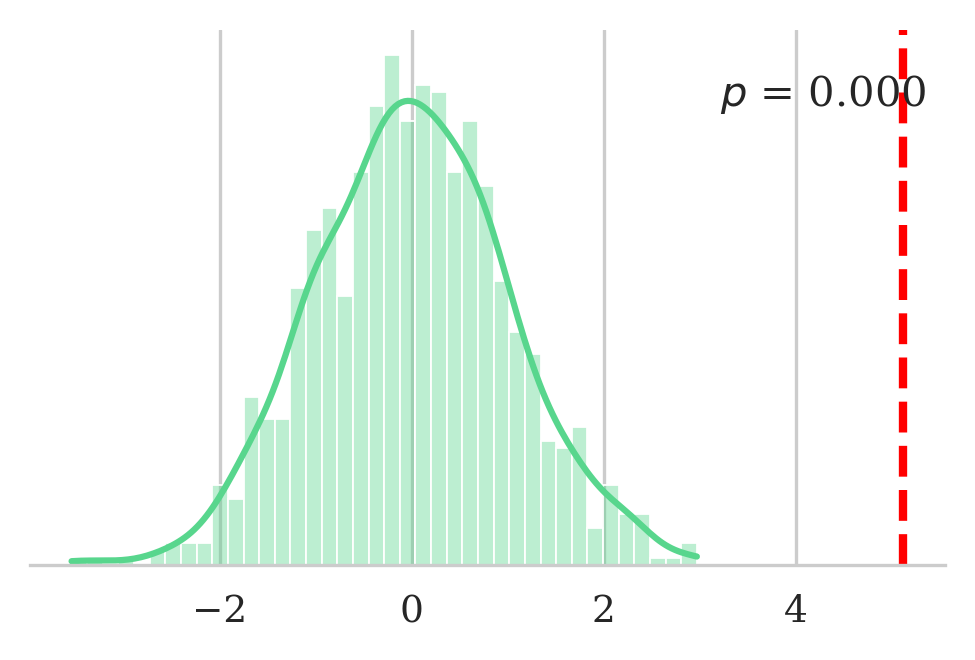

In [23]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# --- style (light CVPR-ish) ---
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---- prepare data (safe for torch/np) ----
def to_float_cpu_1d(x):
    if isinstance(x, torch.Tensor):
        return x.detach().to("cpu", dtype=torch.float32).flatten()
    x = np.asarray(x, dtype=np.float64).ravel()
    return torch.from_numpy(x.astype(np.float32))

perm = to_float_cpu_1d(perm_posterior_medians)
ref  = float(to_float_cpu_1d([np.median(real_posterior_avgs)]).item())

# center by permutation mean
perm_centered = (perm - perm.mean())/perm.std()
ref_centered  = (ref - perm.mean())/perm.std()

# ---- p-value (right-tailed by default) ----
pval = (perm_centered >= ref_centered).float().mean().item() 
# for two-sided instead, use: pval = (perm_centered.abs() >= abs(ref_centered)).float().mean().item()

# ---- plot ----
fig = plt.figure(figsize=(3.35, 2.3))   # ~1-column width
ax  = fig.add_subplot(1,1,1)

sns.histplot(
    perm_centered.numpy(),
    bins=40, stat="probability", kde=True,
    color="#58D68D", alpha=0.4, edgecolor=None, ax=ax
)

ax.axvline(ref_centered, color="red", linestyle="--", linewidth=2)
# remove ALL y-axis stuff
ax.set_yticks([])
ax.set_ylabel("")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# also: remove horizontal grid lines if you want full minimalism
ax.grid(False, axis='y')

#ax.set_xlabel("Centered median value")
#ax.set_ylabel("Probability")
ax.text(0.98, 0.92, rf"$p$ = {pval:.3f}", transform=ax.transAxes,
        ha="right", va="top")

fig.tight_layout()
fig.savefig("posterior_permtest.pdf", bbox_inches="tight")
plt.show()


In [9]:
embcfgs = [3.0, 5.0, 6.0, 9.0]
pipe_cfg = 5.0
seed     = 42

user_idx = range(210)

# base dirs
base_prior_dir   = "../data/flickr/evaluation/diffusion_priors/models/samples"
base_rebeca_dir  = rebeca_dir  # you already defined this above

# storage:
prior_embeddings_per_cfg     = {}    # dict: embcfg -> Tensor
rebeca_embeddings_per_cfg    = {}    # dict: embcfg -> Tensor
u_ids_per_cfg                = {}    # dict: embcfg -> Tensor

# loop over embcfg
for embcfg in embcfgs:
    prefix = f"embcfg_{embcfg}_pipecfg_{pipe_cfg}_seed_{seed}"
    data_dir = f"{base_prior_dir}/{prefix}"
    data_dir_rebeca = f"{base_rebeca_dir}/samples/{prefix}"

    prior_emb_list  = []
    rebeca_emb_list = []

    for user_id in tqdm(user_idx, desc=f"embcfg {embcfg}"):
        # load prior data
        user_data = torch.load(f"{data_dir}/{prefix}_userid_{user_id}.data", weights_only=False)
        prior_emb_list.append(user_data["prior_embeddings"])

        # load REBECA images then encode
        rebeca_user_images = torch.load(
            f"{data_dir_rebeca}/{prefix}_userid_{user_id}.data",
            weights_only=False
        )["images"]

        for img in rebeca_user_images:
            e = pipe_xl.encode_image(img, device="cuda", num_images_per_prompt=1)[0]
            rebeca_emb_list.append(e.detach().cpu())

    # stack
    prior_embeddings     = torch.cat(prior_emb_list)
    posterior_embeddings = torch.cat(rebeca_emb_list)

    # user ids for this cfg  (25 images per user)
    n = prior_embeddings.shape[0]
    u_ids = torch.tensor([i//25 for i in range(n)])

    # store into dicts
    prior_embeddings_per_cfg[embcfg]  = prior_embeddings
    rebeca_embeddings_per_cfg[embcfg] = posterior_embeddings
    u_ids_per_cfg[embcfg]             = u_ids


embcfg 9.0: 100%|██████████| 210/210 [06:53<00:00,  1.97s/it]


In [14]:
rebeca_embeddings_per_cfg[6.0].shape

torch.Size([5250, 1280])

In [17]:
NUM_USERS = 210  # or len(user_idx) if you pass that around

def make_u_ids_for_embeddings(E, num_users=NUM_USERS):
    n = E.shape[0]
    assert n % num_users == 0, f"Samples ({n}) not divisible by users ({num_users})."
    per_user = n // num_users
    return torch.arange(num_users).repeat_interleave(per_user)
prior_embeddings_per_cfg[embcfg]  = prior_embeddings
rebeca_embeddings_per_cfg[embcfg] = posterior_embeddings
u_ids_per_cfg[embcfg]             = make_u_ids_for_embeddings(posterior_embeddings)

for cfg in [3.0,5.0,6.0,9.0]:
    U = u_ids_per_cfg[cfg]
    print(cfg, int(U.min().item()), int(U.max().item()),
          "per_user =", (U == 0).sum().item())



3.0 0 209 per_user = 25
5.0 0 209 per_user = 25
6.0 0 209 per_user = 25
9.0 0 209 per_user = 100


In [20]:
import torch
from tqdm import tqdm

@torch.no_grad()
def posterior_perm_medians_for_cfgs(ncf,
                                    rebeca_embeddings_per_cfg,  # dict: embcfg -> Tensor [N, D]
                                    u_ids_per_cfg,              # dict: embcfg -> Tensor [N]
                                    n_perms=1000,
                                    seed=42):
    """
    Returns:
      results: { embcfg: {
          'perm_medians': Tensor[n_perms],   # permutation distribution of medians
          'real_median' : float,             # median under true assignment
          'p_right'     : float,             # P(perm >= real)
          'num_users'   : int
      } }
    """
    assert ncf.model is not None, "ncf.model must be fitted."
    device = next(ncf.model.parameters()).device

    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    results = {}
    for embcfg, E_cpu in rebeca_embeddings_per_cfg.items():
        # tensors & dtypes
        E = E_cpu.to(device=device, dtype=torch.float32)
        U = u_ids_per_cfg[embcfg].to(device=device, dtype=torch.long)

        # real assignment
        real_scores = ncf.score(U, E)  # dict: user -> {'avg': ...}
        real_avgs = torch.tensor([real_scores[k]['avg'] for k in real_scores.keys()],
                                 dtype=torch.float32)
        real_median = float(real_avgs.median().item())

        # permutations (right-tailed by default)
        perm_medians = torch.empty(n_perms, dtype=torch.float32, device=device)
        N = U.shape[0]
        for i in tqdm(range(n_perms), desc=f"Posterior perms (embcfg={embcfg})"):
            idx = torch.randperm(N, generator=g, device=device)
            U_perm = U[idx]
            s = ncf.score(U_perm, E)
            m = torch.tensor([s[k]['avg'] for k in s.keys()],
                             dtype=torch.float32, device=device).median()
            perm_medians[i] = m

        # center on CPU for analysis/plotting if you like
        perm_medians_cpu = perm_medians.cpu()

        # one-sided p-value: P(perm >= real)
        p_right = float((perm_medians_cpu >= real_median).float().mean().item())

        results[embcfg] = {
            'perm_medians': perm_medians_cpu,   # Tensor [n_perms]
            'real_median' : real_median,        # float
            'p_right'     : p_right,
            'num_users'   : int(torch.unique(U.cpu()).numel()),
        }

    return results


embcfgs = [3.0, 5.0, 6.0, 9.0]

# rebeca_embeddings_per_cfg[embcfg]  -> Tensor [N, D]
# u_ids_per_cfg[embcfg]              -> Tensor [N]
# ncf is your fitted posterior NCF

results = posterior_perm_medians_for_cfgs(
    ncf,
    rebeca_embeddings_per_cfg,
    u_ids_per_cfg,
    n_perms=1000,
    seed=42
)




Posterior perms (embcfg=9.0): 100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s]


embcfg=5.0 median: 0.7662876844406128   p_right: 0.0


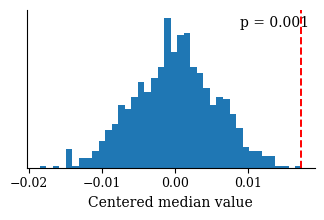

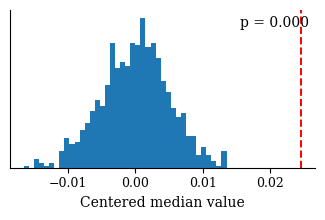

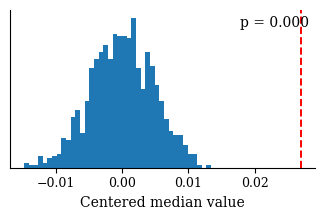

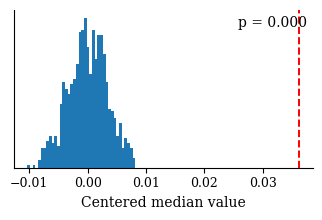

In [21]:
# Example: fetch numbers for a given cfg
r5 = results[5.0]
print("embcfg=5.0 median:", r5['real_median'], "  p_right:", r5['p_right'])


import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_cvpr_perm_one(cfg, results, outfile=None):
    """
    cfg: the embcfg (3.0, 5.0, 6.0, 9.0)
    results: dictionary returned by posterior_perm_medians_for_cfgs
    """

    # CVPR-ish
    mpl.rcParams.update({
        "font.family": "serif",
        "font.size": 10,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
    })

    perm = results[cfg]['perm_medians'].float().cpu()
    real = results[cfg]['real_median']
    p    = results[cfg]['p_right']

    center = perm - perm.mean()

    fig = plt.figure(figsize=(3.35,2.3))  # single column CVPR
    ax  = fig.add_subplot(1,1,1)

    # histogram
    ax.hist(center.numpy(), bins=40, density=True)

    # real median line (centered too)
    ax.axvline(real - perm.mean().item(),
               linestyle="--", color="red", linewidth=1.4)

    ax.set_xlabel("Centered median value")
    ax.set_yticks([])

    # tiny p-value text in corner (allowed in CVPR – annotation is ok)
    ax.text(0.98, 0.96, f"p = {p:.3f}",
            ha="right", va="top", transform=ax.transAxes)

    fig.tight_layout()
    if outfile is not None:
        fig.savefig(outfile, bbox_inches="tight")
    return fig


for cfg in [3.0, 5.0, 6.0, 9.0]:
    fig = plot_cvpr_perm_one(cfg, results,
                             outfile=f"perm_median_embcfg_{cfg}.pdf")
